# Phase 1: Environment Setup & Foundation

**Notebook:** `01_environment_setup.ipynb`  
**Phase:** 1 of 9  
**Purpose:** Verify environment setup, configure GPU, create utility functions, and test basic RL environments  
**Author:** Saurabh Jalendra  
**Institution:** BITS Pilani (WILP Division)  
**Date:** November 2025

---

## Table of Contents

1. [System Information](#1-system-information)
2. [Package Imports & Verification](#2-package-imports--verification)
3. [GPU Configuration](#3-gpu-configuration)
4. [Reproducibility Setup](#4-reproducibility-setup)
5. [Utility Functions](#5-utility-functions)
6. [Environment Testing](#6-environment-testing)
7. [Visualization Helpers](#7-visualization-helpers)
8. [Summary & Next Steps](#8-summary--next-steps)

---
## 1. System Information

First, let's verify the system configuration and hardware availability.

In [1]:
"""
Cell: System Information
Purpose: Display system configuration and verify hardware
"""

import platform
import sys
import os
from datetime import datetime

print("=" * 60)
print("QUANTUM-ENHANCED WORLD MODELS - ENVIRONMENT SETUP")
print("=" * 60)
print(f"\nDate: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nSystem Information:")
print(f"  Python Version: {sys.version}")
print(f"  Platform: {platform.platform()}")
print(f"  Processor: {platform.processor()}")
print(f"  Machine: {platform.machine()}")
print(f"  Working Directory: {os.getcwd()}")
print("=" * 60)

QUANTUM-ENHANCED WORLD MODELS - ENVIRONMENT SETUP

Date: 2025-12-17 13:55:06

System Information:
  Python Version: 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
  Platform: Windows-11-10.0.26200-SP0
  Processor: AMD64 Family 26 Model 68 Stepping 0, AuthenticAMD
  Machine: AMD64
  Working Directory: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\notebooks


---
## 2. Package Imports & Verification

Import all required packages and verify versions.

In [2]:
"""
Cell: Core Package Imports
Purpose: Import and verify core scientific computing packages
"""

# Core scientific computing
import numpy as np
import pandas as pd
import scipy

print("Core Scientific Computing:")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  SciPy: {scipy.__version__}")

Core Scientific Computing:
  NumPy: 2.2.6
  Pandas: 2.3.3
  SciPy: 1.16.3


In [3]:
"""
Cell: PyTorch Import & Verification
Purpose: Import PyTorch and verify GPU availability
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("PyTorch Configuration:")
print(f"  PyTorch Version: {torch.__version__}")
print(f"  CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"  GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"  GPU {i}: {props.name}")
        print(f"    - Memory: {props.total_memory / 1024**3:.1f} GB")
        print(f"    - Compute Capability: {props.major}.{props.minor}")

PyTorch Configuration:
  PyTorch Version: 2.10.0.dev20251124+cu128
  CUDA Available: True
  CUDA Version: 12.8
  cuDNN Version: 91002
  GPU Count: 1
  GPU 0: NVIDIA GeForce RTX 5090
    - Memory: 31.8 GB
    - Compute Capability: 12.0


In [4]:
"""
Cell: Visualization Package Imports
Purpose: Import visualization libraries
"""

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Visualization:")
print(f"  Matplotlib: {plt.matplotlib.__version__}")
print(f"  Seaborn: {sns.__version__}")

Visualization:
  Matplotlib: 3.10.7
  Seaborn: 0.13.2


In [5]:
"""
Cell: Gymnasium Import & Verification
Purpose: Import and verify Gymnasium RL library
"""

import gymnasium as gym
from gymnasium import spaces

print("Reinforcement Learning:")
print(f"  Gymnasium: {gym.__version__}")

# List available environments
classic_envs = [env for env in gym.envs.registry.keys() if 'CartPole' in env or 'Pendulum' in env]
print(f"  Classic Control Environments Available: {len(classic_envs)}")
for env in classic_envs[:5]:
    print(f"    - {env}")

Reinforcement Learning:
  Gymnasium: 1.2.2
  Classic Control Environments Available: 12
    - CartPole-v0
    - CartPole-v1
    - Pendulum-v1
    - phys2d/CartPole-v0
    - phys2d/CartPole-v1


In [6]:
"""
Cell: DMControl Import (Optional)
Purpose: Try to import DMControl Suite
"""

DMCONTROL_AVAILABLE = False

try:
    from dm_control import suite
    import mujoco
    DMCONTROL_AVAILABLE = True
    print("DMControl Suite:")
    print(f"  MuJoCo Version: {mujoco.__version__}")
    print(f"  Available domains: {suite.BENCHMARKING}")
except ImportError as e:
    print(f"DMControl Suite: NOT AVAILABLE")
    print(f"  Error: {e}")
    print("  Note: DMControl is optional for Phase 1. Install with:")
    print("        pip install dm-control mujoco")

DMControl Suite:
  MuJoCo Version: 3.3.7
  Available domains: (('acrobot', 'swingup'), ('acrobot', 'swingup_sparse'), ('ball_in_cup', 'catch'), ('cartpole', 'balance'), ('cartpole', 'balance_sparse'), ('cartpole', 'swingup'), ('cartpole', 'swingup_sparse'), ('cheetah', 'run'), ('finger', 'spin'), ('finger', 'turn_easy'), ('finger', 'turn_hard'), ('fish', 'upright'), ('fish', 'swim'), ('hopper', 'stand'), ('hopper', 'hop'), ('humanoid', 'stand'), ('humanoid', 'walk'), ('humanoid', 'run'), ('manipulator', 'bring_ball'), ('pendulum', 'swingup'), ('point_mass', 'easy'), ('reacher', 'easy'), ('reacher', 'hard'), ('swimmer', 'swimmer6'), ('swimmer', 'swimmer15'), ('walker', 'stand'), ('walker', 'walk'), ('walker', 'run'))


In [7]:
"""
Cell: Additional Package Imports
Purpose: Import remaining utility packages
"""

from typing import Dict, List, Tuple, Optional, Union, Any, Callable
from dataclasses import dataclass, field
from collections import deque, defaultdict
import warnings
import time
import json
import yaml
from pathlib import Path
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("\nAll core packages imported successfully!")


All core packages imported successfully!


---
## 3. GPU Configuration

Configure GPU settings for optimal performance.

In [8]:
"""
Cell: Device Configuration
Purpose: Set up compute device (GPU/CPU) with optimal settings
"""

def get_device(prefer_gpu: bool = True) -> torch.device:
    """
    Get the best available compute device.
    
    Parameters
    ----------
    prefer_gpu : bool
        Whether to prefer GPU over CPU if available
    
    Returns
    -------
    torch.device
        The selected compute device
    """
    if prefer_gpu and torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable cuDNN auto-tuner for optimal performance
        torch.backends.cudnn.benchmark = True
        # Enable TF32 for better performance on Ampere+ GPUs
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    else:
        device = torch.device("cpu")
    
    return device


# Set global device
DEVICE = get_device()
print(f"Using device: {DEVICE}")

if DEVICE.type == "cuda":
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"cuDNN Benchmark: {torch.backends.cudnn.benchmark}")

Using device: cuda
GPU Memory: 31.8 GB
cuDNN Benchmark: True


In [9]:
"""
Cell: GPU Memory Test
Purpose: Test GPU memory and compute capability
"""

def test_gpu_compute() -> Dict[str, Any]:
    """
    Test GPU compute capability with a simple matrix multiplication.
    
    Returns
    -------
    Dict[str, Any]
        Test results including time and memory usage
    """
    results = {"device": str(DEVICE)}
    
    # Test matrix size
    size = 4096
    
    # Create random matrices
    a = torch.randn(size, size, device=DEVICE)
    b = torch.randn(size, size, device=DEVICE)
    
    # Warmup
    for _ in range(3):
        _ = torch.mm(a, b)
    
    if DEVICE.type == "cuda":
        torch.cuda.synchronize()
    
    # Timed run
    start = time.perf_counter()
    for _ in range(10):
        c = torch.mm(a, b)
    
    if DEVICE.type == "cuda":
        torch.cuda.synchronize()
    
    elapsed = (time.perf_counter() - start) / 10
    
    results["matrix_size"] = size
    results["time_per_matmul_ms"] = elapsed * 1000
    results["tflops"] = (2 * size**3) / elapsed / 1e12
    
    if DEVICE.type == "cuda":
        results["gpu_memory_allocated_mb"] = torch.cuda.memory_allocated() / 1024**2
        results["gpu_memory_cached_mb"] = torch.cuda.memory_reserved() / 1024**2
    
    # Cleanup
    del a, b, c
    if DEVICE.type == "cuda":
        torch.cuda.empty_cache()
    
    return results


# Run GPU test
gpu_results = test_gpu_compute()
print("GPU Compute Test Results:")
for key, value in gpu_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

GPU Compute Test Results:
  device: cuda
  matrix_size: 4096
  time_per_matmul_ms: 1.59
  tflops: 86.54
  gpu_memory_allocated_mb: 200.12
  gpu_memory_cached_mb: 276.00


---
## 4. Reproducibility Setup

Set up seeds and deterministic settings for reproducible experiments.

In [10]:
"""
Cell: Reproducibility Functions
Purpose: Create functions for setting random seeds
"""

def set_seed(seed: int = 42, deterministic: bool = True) -> None:
    """
    Set random seeds for reproducibility across all libraries.
    
    Parameters
    ----------
    seed : int
        Random seed value
    deterministic : bool
        Whether to enable deterministic algorithms (may reduce performance)
    """
    import random
    
    # Python random
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        # PyTorch 1.8+ deterministic algorithms
        if hasattr(torch, 'use_deterministic_algorithms'):
            try:
                torch.use_deterministic_algorithms(True)
            except RuntimeError:
                # Some operations don't have deterministic implementations
                pass
    
    # Environment variable for CUDA determinism
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['PYTHONHASHSEED'] = str(seed)


# Set default seed
SEED = 42
set_seed(SEED)
print(f"Random seed set to: {SEED}")
print(f"Deterministic mode: enabled")

Random seed set to: 42
Deterministic mode: enabled


In [11]:
"""
Cell: Verify Reproducibility
Purpose: Test that random number generation is reproducible
"""

def verify_reproducibility(seed: int = 42) -> bool:
    """
    Verify that setting the seed produces reproducible results.
    
    Parameters
    ----------
    seed : int
        Seed to test
    
    Returns
    -------
    bool
        True if results are reproducible
    """
    # First run
    set_seed(seed)
    np_result1 = np.random.rand(5)
    torch_result1 = torch.rand(5)
    
    # Second run
    set_seed(seed)
    np_result2 = np.random.rand(5)
    torch_result2 = torch.rand(5)
    
    np_match = np.allclose(np_result1, np_result2)
    torch_match = torch.allclose(torch_result1, torch_result2)
    
    return np_match and torch_match


reproducible = verify_reproducibility(SEED)
print(f"Reproducibility verified: {reproducible}")
if not reproducible:
    print("WARNING: Results may not be reproducible!")

Reproducibility verified: True


---
## 5. Utility Functions

Create utility functions for logging, timing, and common operations.

In [12]:
"""
Cell: Logging Utilities
Purpose: Create logging helper functions
"""

@dataclass
class MetricLogger:
    """
    Simple metric logger for tracking training progress.
    
    Attributes
    ----------
    name : str
        Name of the logger
    metrics : Dict[str, List[float]]
        Dictionary of metric names to values
    """
    name: str
    metrics: Dict[str, List[float]] = field(default_factory=lambda: defaultdict(list))
    
    def log(self, **kwargs) -> None:
        """Log metric values."""
        for key, value in kwargs.items():
            self.metrics[key].append(value)
    
    def get(self, key: str) -> List[float]:
        """Get all values for a metric."""
        return self.metrics[key]
    
    def get_last(self, key: str, n: int = 1) -> Union[float, List[float]]:
        """Get last n values for a metric."""
        values = self.metrics[key][-n:]
        return values[0] if n == 1 else values
    
    def get_mean(self, key: str, n: Optional[int] = None) -> float:
        """Get mean of last n values (or all if n is None)."""
        values = self.metrics[key]
        if n is not None:
            values = values[-n:]
        return np.mean(values) if values else 0.0
    
    def to_dataframe(self) -> pd.DataFrame:
        """Convert metrics to a pandas DataFrame."""
        return pd.DataFrame(dict(self.metrics))
    
    def save(self, path: Union[str, Path]) -> None:
        """Save metrics to CSV file."""
        self.to_dataframe().to_csv(path, index=False)
    
    def __repr__(self) -> str:
        return f"MetricLogger(name='{self.name}', metrics={list(self.metrics.keys())})"


# Test the logger
test_logger = MetricLogger(name="test")
for i in range(10):
    test_logger.log(loss=1.0/(i+1), reward=i*10)

print(f"Logger: {test_logger}")
print(f"Mean loss: {test_logger.get_mean('loss'):.4f}")
print(f"Last 3 rewards: {test_logger.get_last('reward', 3)}")

Logger: MetricLogger(name='test', metrics=['loss', 'reward'])
Mean loss: 0.2929
Last 3 rewards: [70, 80, 90]


In [13]:
"""
Cell: Timing Utilities
Purpose: Create timing helper functions and context managers
"""

import contextlib

@contextlib.contextmanager
def timer(name: str = "Operation"):
    """
    Context manager for timing code blocks.
    
    Parameters
    ----------
    name : str
        Name of the operation being timed
    
    Yields
    ------
    Dict with timing info
    """
    start = time.perf_counter()
    timing_info = {"name": name}
    try:
        yield timing_info
    finally:
        elapsed = time.perf_counter() - start
        timing_info["elapsed"] = elapsed
        print(f"{name}: {elapsed:.4f}s")


class Timer:
    """
    Reusable timer class for tracking multiple operations.
    
    Examples
    --------
    >>> t = Timer()
    >>> t.start()
    >>> # ... do something ...
    >>> elapsed = t.stop()
    """
    
    def __init__(self):
        self._start_time = None
        self._elapsed = 0.0
        self._running = False
    
    def start(self) -> 'Timer':
        """Start the timer."""
        if not self._running:
            self._start_time = time.perf_counter()
            self._running = True
        return self
    
    def stop(self) -> float:
        """Stop the timer and return elapsed time."""
        if self._running:
            self._elapsed = time.perf_counter() - self._start_time
            self._running = False
        return self._elapsed
    
    def reset(self) -> 'Timer':
        """Reset the timer."""
        self._start_time = None
        self._elapsed = 0.0
        self._running = False
        return self
    
    @property
    def elapsed(self) -> float:
        """Get elapsed time."""
        if self._running:
            return time.perf_counter() - self._start_time
        return self._elapsed


# Test timing utilities
with timer("Test computation"):
    _ = torch.randn(1000, 1000, device=DEVICE) @ torch.randn(1000, 1000, device=DEVICE)
    if DEVICE.type == "cuda":
        torch.cuda.synchronize()

Test computation: 0.0101s


In [14]:
"""
Cell: Configuration Utilities
Purpose: Load and manage configuration files
"""

def load_config(path: Union[str, Path]) -> Dict[str, Any]:
    """
    Load configuration from YAML file.
    
    Parameters
    ----------
    path : Union[str, Path]
        Path to YAML configuration file
    
    Returns
    -------
    Dict[str, Any]
        Configuration dictionary
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Config file not found: {path}")
    
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    
    return config


def save_config(config: Dict[str, Any], path: Union[str, Path]) -> None:
    """
    Save configuration to YAML file.
    
    Parameters
    ----------
    config : Dict[str, Any]
        Configuration dictionary
    path : Union[str, Path]
        Path to save YAML file
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False)


# Test config loading
try:
    config_path = Path("../configs/default.yaml")
    if config_path.exists():
        config = load_config(config_path)
        print("Loaded default configuration:")
        print(f"  Environment: {config.get('environment', {}).get('name', 'N/A')}")
        print(f"  Seed: {config.get('seed', 'N/A')}")
        print(f"  Device: {config.get('device', 'N/A')}")
    else:
        print(f"Config file not found at {config_path}")
except Exception as e:
    print(f"Error loading config: {e}")

Loaded default configuration:
  Environment: CartPole-v1
  Seed: 42
  Device: auto


In [15]:
"""
Cell: Path Utilities
Purpose: Helper functions for project paths
"""

def get_project_root() -> Path:
    """
    Get the project root directory.
    
    Returns
    -------
    Path
        Path to project root
    """
    # Navigate up from notebooks directory
    current = Path.cwd()
    while current.name != "Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning" and current.parent != current:
        current = current.parent
    return current


PROJECT_ROOT = get_project_root()
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
SRC_DIR = PROJECT_ROOT / "src"
CONFIGS_DIR = PROJECT_ROOT / "configs"
EXPERIMENTS_DIR = PROJECT_ROOT / "experiments"
FIGURES_DIR = PROJECT_ROOT / "figures"

print(f"Project Root: {PROJECT_ROOT}")
print(f"Source Dir: {SRC_DIR}")
print(f"Configs Dir: {CONFIGS_DIR}")

Project Root: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning
Source Dir: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\src
Configs Dir: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\configs


---
## 6. Environment Testing

Test the RL environments to ensure they work correctly.

In [16]:
"""
Cell: CartPole Environment Test
Purpose: Test CartPole-v1 environment
"""

def test_environment(env_name: str, num_episodes: int = 3, max_steps: int = 100) -> Dict[str, Any]:
    """
    Test a Gymnasium environment with random actions.
    
    Parameters
    ----------
    env_name : str
        Name of the Gymnasium environment
    num_episodes : int
        Number of episodes to run
    max_steps : int
        Maximum steps per episode
    
    Returns
    -------
    Dict[str, Any]
        Test results including observations, actions, rewards
    """
    env = gym.make(env_name)
    
    results = {
        "env_name": env_name,
        "observation_space": str(env.observation_space),
        "action_space": str(env.action_space),
        "episodes": [],
    }
    
    for ep in range(num_episodes):
        obs, info = env.reset(seed=SEED + ep)
        episode_data = {
            "episode": ep,
            "observations": [obs],
            "actions": [],
            "rewards": [],
            "total_reward": 0.0,
            "steps": 0,
        }
        
        for step in range(max_steps):
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            
            episode_data["actions"].append(action)
            episode_data["rewards"].append(reward)
            episode_data["observations"].append(obs)
            episode_data["total_reward"] += reward
            episode_data["steps"] = step + 1
            
            if terminated or truncated:
                break
        
        results["episodes"].append(episode_data)
    
    env.close()
    return results


# Test CartPole
print("Testing CartPole-v1 Environment:")
print("=" * 40)

cartpole_results = test_environment("CartPole-v1", num_episodes=3, max_steps=200)

print(f"Observation Space: {cartpole_results['observation_space']}")
print(f"Action Space: {cartpole_results['action_space']}")
print("\nEpisode Results:")
for ep_data in cartpole_results["episodes"]:
    print(f"  Episode {ep_data['episode']}: {ep_data['steps']} steps, reward = {ep_data['total_reward']:.1f}")

Testing CartPole-v1 Environment:
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action Space: Discrete(2)

Episode Results:
  Episode 0: 22 steps, reward = 22.0
  Episode 1: 18 steps, reward = 18.0
  Episode 2: 18 steps, reward = 18.0


In [17]:
"""
Cell: Pendulum Environment Test
Purpose: Test Pendulum-v1 environment (continuous action space)
"""

print("\nTesting Pendulum-v1 Environment:")
print("=" * 40)

pendulum_results = test_environment("Pendulum-v1", num_episodes=3, max_steps=100)

print(f"Observation Space: {pendulum_results['observation_space']}")
print(f"Action Space: {pendulum_results['action_space']}")
print("\nEpisode Results:")
for ep_data in pendulum_results["episodes"]:
    print(f"  Episode {ep_data['episode']}: {ep_data['steps']} steps, reward = {ep_data['total_reward']:.1f}")


Testing Pendulum-v1 Environment:
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action Space: Box(-2.0, 2.0, (1,), float32)

Episode Results:
  Episode 0: 100 steps, reward = -589.9
  Episode 1: 100 steps, reward = -503.6
  Episode 2: 100 steps, reward = -711.4


In [18]:
"""
Cell: Experience Collection
Purpose: Collect experience tuples for world model training
"""

@dataclass
class Experience:
    """
    Single experience tuple (s, a, r, s', done).
    
    Attributes
    ----------
    observation : np.ndarray
        Current observation
    action : Union[int, np.ndarray]
        Action taken
    reward : float
        Reward received
    next_observation : np.ndarray
        Next observation
    done : bool
        Whether episode terminated
    """
    observation: np.ndarray
    action: Union[int, np.ndarray]
    reward: float
    next_observation: np.ndarray
    done: bool


def collect_experiences(
    env_name: str,
    num_steps: int = 1000,
    seed: int = 42
) -> List[Experience]:
    """
    Collect experience tuples from an environment.
    
    Parameters
    ----------
    env_name : str
        Name of the environment
    num_steps : int
        Number of steps to collect
    seed : int
        Random seed
    
    Returns
    -------
    List[Experience]
        List of experience tuples
    """
    env = gym.make(env_name)
    experiences = []
    
    obs, _ = env.reset(seed=seed)
    
    for _ in range(num_steps):
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        experiences.append(Experience(
            observation=obs.copy(),
            action=action,
            reward=float(reward),
            next_observation=next_obs.copy(),
            done=done
        ))
        
        if done:
            obs, _ = env.reset()
        else:
            obs = next_obs
    
    env.close()
    return experiences


# Collect some experiences
print("Collecting experiences from CartPole-v1...")
experiences = collect_experiences("CartPole-v1", num_steps=500, seed=SEED)
print(f"Collected {len(experiences)} experience tuples")
print(f"  Observation shape: {experiences[0].observation.shape}")
print(f"  Action type: {type(experiences[0].action)}")
print(f"  Sample reward: {experiences[0].reward}")

Collected 500 experience tuples
  Observation shape: (4,)
  Action type: <class 'numpy.int64'>
  Sample reward: 1.0


---
## 7. Visualization Helpers

Create visualization utility functions for training curves and environment rendering.

In [19]:
"""
Cell: Visualization Style Configuration
Purpose: Set up consistent visualization style
"""

# Color palette for different approaches
COLORS = {
    "baseline": "#2ecc71",      # Green
    "qaoa": "#3498db",          # Blue
    "superposition": "#9b59b6", # Purple
    "gates": "#e74c3c",         # Red
    "error_correction": "#f39c12",  # Orange
    "integrated": "#1abc9c",    # Teal
}

# Figure defaults
FIGURE_DEFAULTS = {
    "figsize": (10, 6),
    "dpi": 100,
    "facecolor": "white",
}

def setup_figure_style():
    """Set up matplotlib figure style."""
    plt.rcParams.update({
        'figure.figsize': FIGURE_DEFAULTS['figsize'],
        'figure.dpi': FIGURE_DEFAULTS['dpi'],
        'figure.facecolor': FIGURE_DEFAULTS['facecolor'],
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'font.family': 'sans-serif',
    })

setup_figure_style()
print("Visualization style configured.")

Visualization style configured.


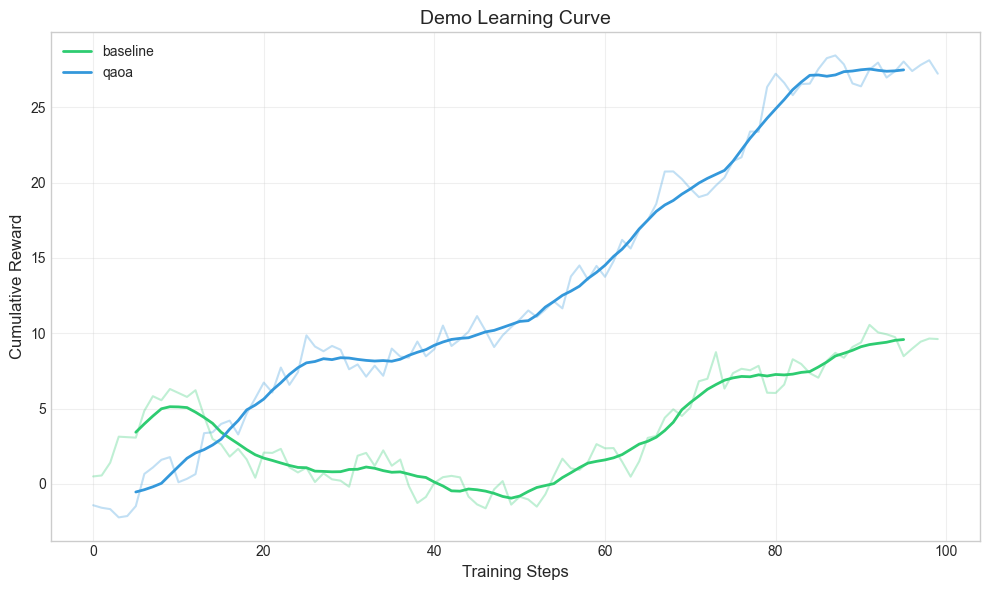

In [20]:
"""
Cell: Learning Curve Plotting
Purpose: Functions for plotting training curves
"""

def plot_learning_curve(
    data: Dict[str, List[float]],
    title: str = "Learning Curve",
    xlabel: str = "Steps",
    ylabel: str = "Value",
    smooth_window: int = 10,
    figsize: Tuple[int, int] = (10, 6),
    save_path: Optional[str] = None
) -> plt.Figure:
    """
    Plot learning curves with optional smoothing.
    
    Parameters
    ----------
    data : Dict[str, List[float]]
        Dictionary mapping method names to value lists
    title : str
        Plot title
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
    smooth_window : int
        Window size for moving average smoothing
    figsize : Tuple[int, int]
        Figure size
    save_path : Optional[str]
        Path to save figure
    
    Returns
    -------
    plt.Figure
        The matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    for name, values in data.items():
        color = COLORS.get(name, None)
        x = np.arange(len(values))
        
        # Raw data (lighter)
        ax.plot(x, values, alpha=0.3, color=color)
        
        # Smoothed data
        if len(values) >= smooth_window:
            smoothed = np.convolve(values, np.ones(smooth_window)/smooth_window, mode='valid')
            ax.plot(np.arange(len(smoothed)) + smooth_window//2, smoothed, 
                   label=name, color=color, linewidth=2)
        else:
            ax.plot(x, values, label=name, color=color, linewidth=2)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    return fig


# Demo plot with synthetic data
np.random.seed(SEED)
demo_data = {
    "baseline": np.cumsum(np.random.randn(100)) + np.linspace(0, 20, 100),
    "qaoa": np.cumsum(np.random.randn(100)) + np.linspace(0, 25, 100),
}

fig = plot_learning_curve(
    demo_data,
    title="Demo Learning Curve",
    xlabel="Training Steps",
    ylabel="Cumulative Reward"
)
plt.show()

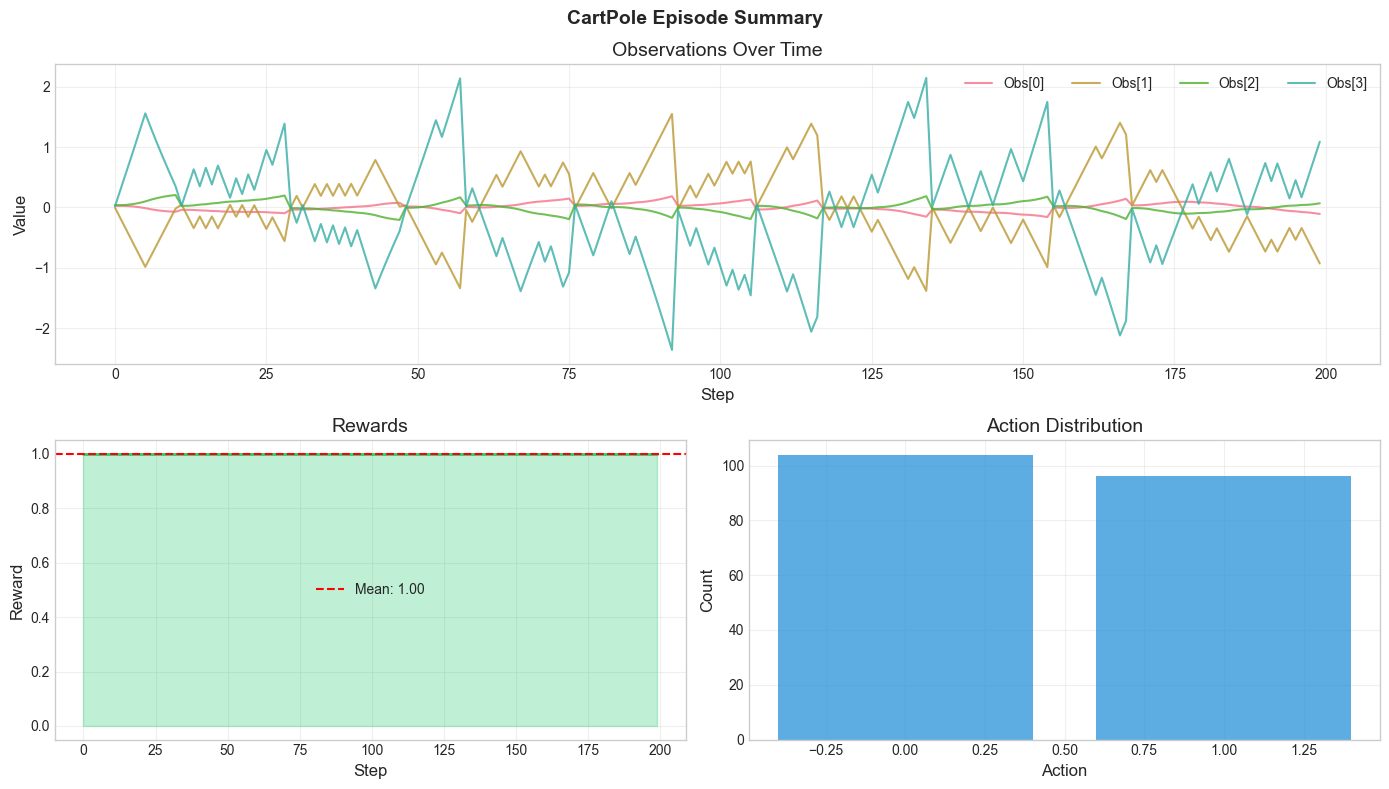

In [21]:
"""
Cell: Episode Visualization
Purpose: Visualize episode observations and rewards
"""

def plot_episode_summary(
    experiences: List[Experience],
    title: str = "Episode Summary",
    figsize: Tuple[int, int] = (14, 8)
) -> plt.Figure:
    """
    Plot summary of an episode's observations and rewards.
    
    Parameters
    ----------
    experiences : List[Experience]
        List of experience tuples
    title : str
        Plot title
    figsize : Tuple[int, int]
        Figure size
    
    Returns
    -------
    plt.Figure
        The matplotlib figure
    """
    obs = np.array([e.observation for e in experiences])
    rewards = np.array([e.reward for e in experiences])
    actions = np.array([e.action for e in experiences])
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig)
    
    # Plot 1: Observations over time
    ax1 = fig.add_subplot(gs[0, :])
    for i in range(obs.shape[1]):
        ax1.plot(obs[:, i], label=f"Obs[{i}]", alpha=0.8)
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Value")
    ax1.set_title("Observations Over Time")
    ax1.legend(loc='upper right', ncol=obs.shape[1])
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Rewards
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(rewards, color=COLORS["baseline"], linewidth=2)
    ax2.fill_between(range(len(rewards)), rewards, alpha=0.3, color=COLORS["baseline"])
    ax2.axhline(y=np.mean(rewards), color='red', linestyle='--', label=f"Mean: {np.mean(rewards):.2f}")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Reward")
    ax2.set_title("Rewards")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Action distribution
    ax3 = fig.add_subplot(gs[1, 1])
    if isinstance(actions[0], (int, np.integer)):
        unique, counts = np.unique(actions, return_counts=True)
        ax3.bar(unique, counts, color=COLORS["qaoa"], alpha=0.8)
        ax3.set_xlabel("Action")
        ax3.set_ylabel("Count")
    else:
        ax3.hist(actions.flatten(), bins=30, color=COLORS["qaoa"], alpha=0.8)
        ax3.set_xlabel("Action Value")
        ax3.set_ylabel("Frequency")
    ax3.set_title("Action Distribution")
    ax3.grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig


# Plot episode summary for collected experiences
fig = plot_episode_summary(experiences[:200], title="CartPole Episode Summary")
plt.show()

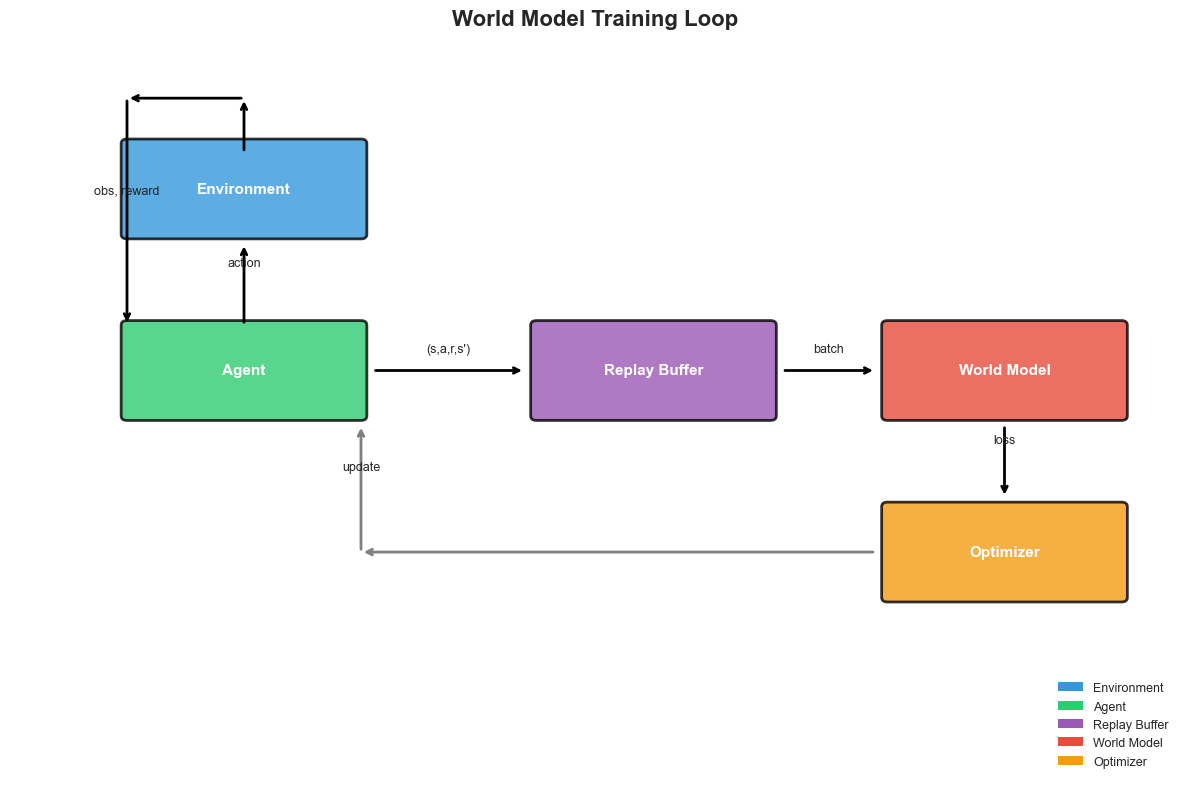

In [22]:
"""
Cell: Training Loop Diagram
Purpose: Create a visual diagram of the training loop
"""

def create_training_loop_diagram(figsize: Tuple[int, int] = (12, 8)) -> plt.Figure:
    """
    Create a visual diagram of the world model training loop.
    
    Returns
    -------
    plt.Figure
        The matplotlib figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Define box positions and sizes
    boxes = {
        'Environment': (1, 6, 2, 1, '#3498db'),
        'Agent': (1, 4, 2, 1, '#2ecc71'),
        'Replay Buffer': (4.5, 4, 2, 1, '#9b59b6'),
        'World Model': (7.5, 4, 2, 1, '#e74c3c'),
        'Optimizer': (7.5, 2, 2, 1, '#f39c12'),
    }
    
    # Draw boxes
    for name, (x, y, w, h, color) in boxes.items():
        rect = mpatches.FancyBboxPatch(
            (x, y), w, h,
            boxstyle="round,pad=0.05",
            facecolor=color,
            edgecolor='black',
            linewidth=2,
            alpha=0.8
        )
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, name, ha='center', va='center',
               fontsize=11, fontweight='bold', color='white')
    
    # Draw arrows with labels
    arrows = [
        # (start, end, label, color)
        ((2, 5), (2, 5.9), "action", 'black'),
        ((2, 6.9), (2, 7.5), "", 'black'),
        ((2, 7.5), (1, 7.5), "", 'black'),
        ((1, 7.5), (1, 5), "obs, reward", 'black'),
        ((3.1, 4.5), (4.4, 4.5), "(s,a,r,s')", 'black'),
        ((6.6, 4.5), (7.4, 4.5), "batch", 'black'),
        ((8.5, 3.9), (8.5, 3.1), "loss", 'black'),
        ((7.4, 2.5), (3, 2.5), "", 'gray'),
        ((3, 2.5), (3, 3.9), "update", 'gray'),
    ]
    
    for start, end, label, color in arrows:
        ax.annotate(
            '', xy=end, xytext=start,
            arrowprops=dict(arrowstyle='->', color=color, lw=2)
        )
        if label:
            mid = ((start[0] + end[0])/2, (start[1] + end[1])/2)
            ax.text(mid[0], mid[1] + 0.2, label, ha='center', fontsize=9)
    
    ax.set_title("World Model Training Loop", fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [
        mpatches.Patch(facecolor='#3498db', label='Environment'),
        mpatches.Patch(facecolor='#2ecc71', label='Agent'),
        mpatches.Patch(facecolor='#9b59b6', label='Replay Buffer'),
        mpatches.Patch(facecolor='#e74c3c', label='World Model'),
        mpatches.Patch(facecolor='#f39c12', label='Optimizer'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    return fig


# Create and display the training loop diagram
fig = create_training_loop_diagram()
plt.tight_layout()
plt.show()

---
## 8. Summary & Next Steps

Summarize the environment setup and outline next steps.

In [23]:
"""
Cell: Environment Summary
Purpose: Display summary of environment setup
"""

print("=" * 60)
print("PHASE 1 COMPLETE: ENVIRONMENT SETUP SUMMARY")
print("=" * 60)

print("\n[1] System Configuration")
print(f"    Python: {sys.version.split()[0]}")
print(f"    Platform: {platform.system()} {platform.release()}")

print("\n[2] Core Libraries")
print(f"    PyTorch: {torch.__version__}")
print(f"    NumPy: {np.__version__}")
print(f"    Gymnasium: {gym.__version__}")

print("\n[3] Hardware")
print(f"    Device: {DEVICE}")
if DEVICE.type == "cuda":
    props = torch.cuda.get_device_properties(0)
    print(f"    GPU: {props.name}")
    print(f"    GPU Memory: {props.total_memory / 1024**3:.1f} GB")

print("\n[4] Environments Tested")
print("    CartPole-v1: OK")
print("    Pendulum-v1: OK")
print(f"    DMControl: {'Available' if DMCONTROL_AVAILABLE else 'Not Installed'}")

print("\n[5] Utilities Created")
print("    MetricLogger: OK")
print("    Timer: OK")
print("    Config loader/saver: OK")
print("    Experience collector: OK")
print("    Visualization helpers: OK")

print("\n[6] Reproducibility")
print(f"    Seed: {SEED}")
print(f"    Reproducibility verified: {reproducible}")

print("\n" + "=" * 60)
print("NEXT STEPS: Phase 2 - Classical Baseline World Model")
print("=" * 60)
print("""
In Phase 2, we will:
  1. Implement the DreamerV3-style RSSM architecture
  2. Create encoder, dynamics, reward, and decoder networks
  3. Implement the training loop with Adam optimizer
  4. Train on CartPole and Pendulum
  5. Visualize loss curves and latent space
""")

PHASE 1 COMPLETE: ENVIRONMENT SETUP SUMMARY

[1] System Configuration
    Python: 3.12.10
    Platform: Windows 11

[2] Core Libraries
    PyTorch: 2.10.0.dev20251124+cu128
    NumPy: 2.2.6
    Gymnasium: 1.2.2

[3] Hardware
    Device: cuda
    GPU: NVIDIA GeForce RTX 5090
    GPU Memory: 31.8 GB

[4] Environments Tested
    CartPole-v1: OK
    Pendulum-v1: OK
    DMControl: Available

[5] Utilities Created
    MetricLogger: OK
    Timer: OK
    Config loader/saver: OK
    Experience collector: OK
    Visualization helpers: OK

[6] Reproducibility
    Seed: 42
    Reproducibility verified: True

NEXT STEPS: Phase 2 - Classical Baseline World Model

In Phase 2, we will:
  1. Implement the DreamerV3-style RSSM architecture
  2. Create encoder, dynamics, reward, and decoder networks
  3. Implement the training loop with Adam optimizer
  4. Train on CartPole and Pendulum
  5. Visualize loss curves and latent space



In [24]:
"""
Cell: Save Utilities to Module
Purpose: Export utility functions to src/utils for reuse
"""

# Create utils module content
utils_content = '''
"""
Utility Functions for Quantum-Enhanced World Models.

Author: Saurabh Jalendra
Institution: BITS Pilani (WILP Division)
"""

import os
import random
import time
import contextlib
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union, Any
from dataclasses import dataclass, field
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import yaml


def set_seed(seed: int = 42, deterministic: bool = True) -> None:
    """
    Set random seeds for reproducibility across all libraries.
    
    Parameters
    ----------
    seed : int
        Random seed value
    deterministic : bool
        Whether to enable deterministic algorithms
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    os.environ[\'CUBLAS_WORKSPACE_CONFIG\'] = \':4096:8\'
    os.environ[\'PYTHONHASHSEED\'] = str(seed)


def get_device(prefer_gpu: bool = True) -> torch.device:
    """
    Get the best available compute device.
    
    Parameters
    ----------
    prefer_gpu : bool
        Whether to prefer GPU over CPU
    
    Returns
    -------
    torch.device
        The selected compute device
    """
    if prefer_gpu and torch.cuda.is_available():
        device = torch.device("cuda")
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    else:
        device = torch.device("cpu")
    return device


@dataclass
class MetricLogger:
    """Simple metric logger for tracking training progress."""
    name: str
    metrics: Dict[str, List[float]] = field(default_factory=lambda: defaultdict(list))
    
    def log(self, **kwargs) -> None:
        for key, value in kwargs.items():
            self.metrics[key].append(value)
    
    def get_mean(self, key: str, n: Optional[int] = None) -> float:
        values = self.metrics[key]
        if n is not None:
            values = values[-n:]
        return np.mean(values) if values else 0.0
    
    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(dict(self.metrics))
    
    def save(self, path: Union[str, Path]) -> None:
        self.to_dataframe().to_csv(path, index=False)


@contextlib.contextmanager
def timer(name: str = "Operation"):
    """Context manager for timing code blocks."""
    start = time.perf_counter()
    timing_info = {"name": name}
    try:
        yield timing_info
    finally:
        elapsed = time.perf_counter() - start
        timing_info["elapsed"] = elapsed
        print(f"{name}: {elapsed:.4f}s")


def load_config(path: Union[str, Path]) -> Dict[str, Any]:
    """Load configuration from YAML file."""
    with open(path, \'r\') as f:
        return yaml.safe_load(f)


def save_config(config: Dict[str, Any], path: Union[str, Path]) -> None:
    """Save configuration to YAML file."""
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, \'w\') as f:
        yaml.dump(config, f, default_flow_style=False)
'''

# Write to file
utils_path = PROJECT_ROOT / "src" / "utils" / "__init__.py"
utils_path.parent.mkdir(parents=True, exist_ok=True)
with open(utils_path, 'w') as f:
    f.write(utils_content)

print(f"Utilities saved to: {utils_path}")

Utilities saved to: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\src\utils\__init__.py


In [25]:
"""
Cell: Final Verification
Purpose: Verify all components are working
"""

print("\nFinal Verification:")
print("-" * 40)

# Test imports from our new module
import sys
sys.path.insert(0, str(PROJECT_ROOT / "src"))

try:
    from utils import set_seed, get_device, MetricLogger, timer
    print("Module imports: OK")
except ImportError as e:
    print(f"Module imports: FAILED ({e})")

# Verify GPU
print(f"GPU available: {torch.cuda.is_available()}")

# Verify environments
try:
    env = gym.make("CartPole-v1")
    obs, _ = env.reset()
    env.close()
    print("CartPole-v1: OK")
except Exception as e:
    print(f"CartPole-v1: FAILED ({e})")

print("-" * 40)
print("\nPhase 1 Complete!")
print("Proceed to: notebooks/02_classical_baseline.ipynb")


Final Verification:
----------------------------------------
Module imports: OK
GPU available: True
CartPole-v1: OK
----------------------------------------

Phase 1 Complete!
Proceed to: notebooks/02_classical_baseline.ipynb
